# House Price Prediction

1. Data preprocessing and EDA(check missing values, one hot encolding categorical vars, standardaize numerical vars, transform response var, etc.)

2. Modeling: Train and tune each model (Rdige; Random Forest; Bagging + Rdige; AdaBoost (skipped); Adaboosting + Rdige; XGBoost). Hyperparameters are optimized by CV then model selection is done by checking MSE.


In [5]:
#Regression Problem
#Predict the houseprice using different features of the house
import numpy as np
import pandas as pd

In [6]:
train_df=pd.read_csv('./sample_data/train.csv',index_col=0)
test_df=pd.read_csv('./sample_data/test.csv',index_col=0)

In [7]:
#check first 5 obs
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<Axes: title={'center': 'price'}>]], dtype=object)

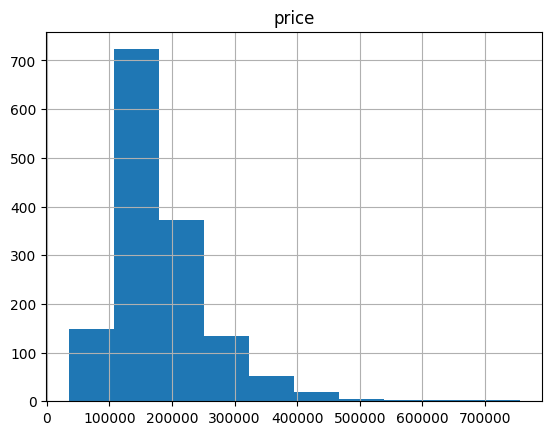

In [8]:
#Preprocess the data; Take SalePrice(response var) out
#The response var is not normally distributted; we then normalize the response var
#log(price+1) to avoid extreme value (log0)
#can use expm1 to transform back
%matplotlib inline
price=pd.DataFrame({'price':train_df['SalePrice']})
price.hist()

array([[<Axes: title={'center': 'log(price+1)'}>]], dtype=object)

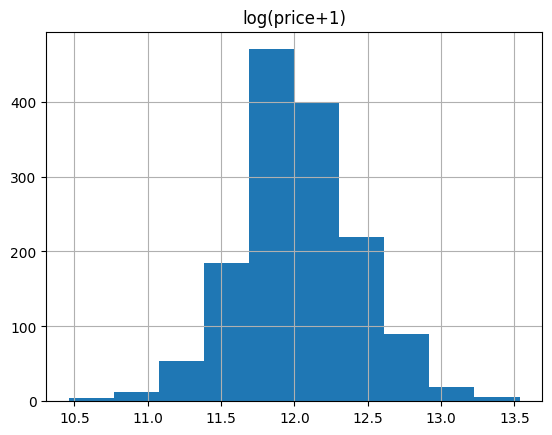

In [9]:
%matplotlib inline
log_price=pd.DataFrame({'log(price+1)':np.log1p(train_df['SalePrice'])})
log_price.hist()

In [10]:
y_train = np.log1p(train_df.pop('SalePrice'))

In [11]:
all_df=pd.concat([train_df,test_df],axis=0)

In [12]:
all_df.shape

(2919, 79)

In [13]:
all_df.tail(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [14]:
#Feature engineering

##Categorical features - one hot encoding
## MSSubClass should be a categorical variable
all_df['MSSubClass'].dtype

dtype('int64')

In [15]:
all_df['MSSubClass']=all_df['MSSubClass'].astype('str')

In [16]:
all_df['MSSubClass'].value_counts

<bound method IndexOpsMixin.value_counts of Id
1        60
2        20
3        60
4        70
5        60
       ... 
2915    160
2916    160
2917     20
2918     85
2919     60
Name: MSSubClass, Length: 2919, dtype: object>

In [17]:
pd.get_dummies(all_df['MSSubClass'],prefix='MSSubClass').head(3)

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90
Id,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [18]:
all_dummy_df=pd.get_dummies(all_df)

In [19]:
#numerical var
###missing value
all_dummy_df.isnull().sum().sort_values(ascending=False).head(15)



,0
LotFrontage,486
GarageYrBlt,159
MasVnrArea,23
BsmtFullBath,2
BsmtHalfBath,2
BsmtUnfSF,1
GarageArea,1
TotalBsmtSF,1
GarageCars,1
BsmtFinSF2,1


In [20]:
##when there's missing value, see what does these missing values represent in the data first
##if missing proportion is low, consider inpute the missing value (e.g.mean, median);
##if the missing proportion is high, delete the column

In [21]:
mean_cols=all_dummy_df.mean()
mean_cols.head(10)

,0
LotFrontage,69.305795
LotArea,10168.114080
OverallQual,6.089072
OverallCond,5.564577
YearBuilt,1971.312778
YearRemodAdd,1984.264474
MasVnrArea,102.201312
BsmtFinSF1,441.423235
BsmtFinSF2,49.582248
BsmtUnfSF,560.772104


In [22]:
##impute the missing values by mean
all_dummy_df=all_dummy_df.fillna(mean_cols)


In [23]:
##no missing value
all_dummy_df.isnull().sum()

,0
LotFrontage,0
LotArea,0
OverallQual,0
OverallCond,0
YearBuilt,0
...,...
SaleCondition_AdjLand,0
SaleCondition_Alloca,0
SaleCondition_Family,0
SaleCondition_Normal,0


In [24]:
#numerical data normalization (optional, particularly useful for regression)
numerical_cols=all_df.columns[all_df.dtypes!='object']
numerical_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [25]:
#we standardize it  (X-mu/S)
numerical_cols_means=all_dummy_df.loc[:,numerical_cols].mean()
numerical_cols_std=all_dummy_df.loc[:,numerical_cols].std()
all_dummy_df.loc[:,numerical_cols]=(all_dummy_df.loc[:, numerical_cols] -numerical_cols_means)/numerical_cols_std

In [26]:
#after normalizing data, we split train and test
dummy_train_df=all_dummy_df.loc[train_df.index]
dummy_test_df=all_dummy_df.loc[test_df.index]

In [27]:
dummy_train_df.shape, dummy_test_df.shape

((1460, 302), (1459, 302))

## Modeling + Ensemble
1. Ridge
2. RandomForestRegressor
3. BaggingRegressor + Ridge
4. XGBoost/AdaBoost + Ridge

## Rdige Regression
Ridge Regression is an extension of linear regression by adding L2 regularization, i.e.the sum of the squares of the coefficients $\beta_j$s. It shrinks the coefficients towards zero but not exactly zero. And therefore useful for dealing with multicolinearity and prevent overfitting.

\(Sidenote: LASSO is L1 regularization,i.e.the absolute value of of the magnitude of coefficients, which can zero out some features and is usful in feature selection. Elastic Net has the combination of L1 and L2 penalty.)

In [28]:
#1.Ridge
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score


In [29]:
##change all df to numpy array for sklearn(optional)
X_train = dummy_train_df.values
X_test = dummy_test_df.values

In [30]:
#save all test_score to find the best alpha for the Ridge regression
alphas=np.logspace(-3,2,50)
test_scores=[]
for alpha in alphas:
    clf=Ridge(alpha)
    test_score=np.sqrt(-cross_val_score(clf,X_train,y_train,cv=10,scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5, 1.0, 'Alpha vs CV error')

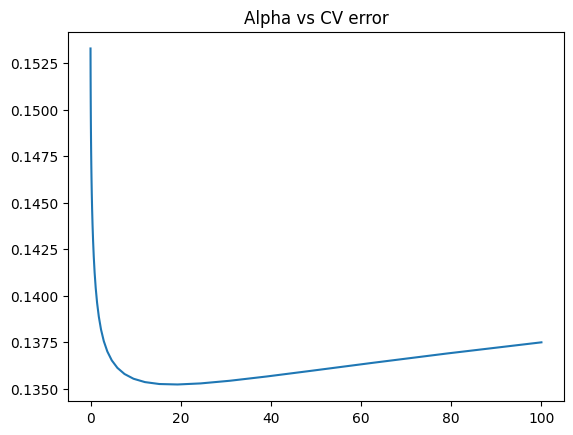

In [31]:
import matplotlib.pyplot as plt
plt.plot(alphas,test_scores)
plt.title("Alpha vs CV error")

In [32]:
ridge=Ridge(15)

Smallest MSE at round 0.135 when alpha between 13-18.

## Random Forest
Random Forest is a special kind of bagging. (1) Create many samples by bootstrap and grow decision trees. (2) Randomly select a subset of all features to grow trees, which prevent overfitting. (3) If it is a classification problem, the result is the majority vote of all trees; if it is a regression problem, the prediction of all trees are averaged.  

In [33]:
#Rndom Forest
from sklearn.ensemble import RandomForestRegressor
max_features=[.1,.2,.3,.5,.7,.9,.99]
test_scores=[]
for max_feat in max_features:
    clf=RandomForestRegressor(n_estimators=200,max_features=max_feat,random_state=5)
    #grow 200 decision trees; max_feat (e.g.30%) of the features are considere when frowing trees;fix the seed of random generation
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))


Text(0.5, 1.0, 'n_estimator vs CV Error')

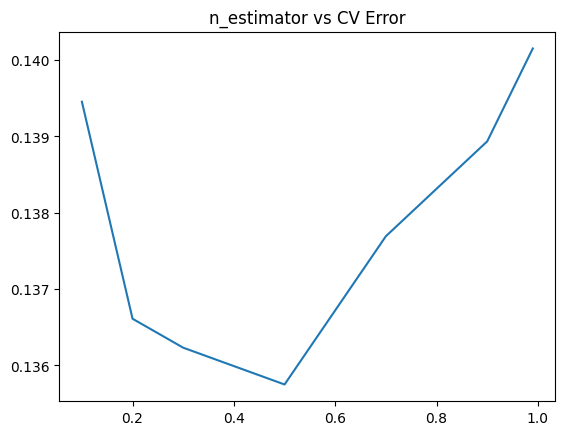

In [34]:
plt.plot(max_features, test_scores)
plt.title("n_estimator vs CV Error")
#The smallest is slightly above 0.136.

In [35]:
#ensemble the best models
ridge=Ridge(15)
rf=RandomForestRegressor(n_estimators=200,max_features=.3,)

In [36]:
ridge.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestRegressor(max_features=0.3, n_estimators=200)

In [37]:
#reverse the log(price+1) operation
y_ridge=np.expm1(ridge.predict(X_test))
y_rf=np.expm1(rf.predict(X_test))

y_final=(y_ridge+y_rf)/2

In [38]:
submission1=pd.DataFrame(data={'Id':test_df.index,'SalePrice':y_final})
submission1.head(4)

,Id,SalePrice
0,1461,119416.513147
1,1462,151991.251736
2,1463,174299.439330
3,1464,189631.189218


In [39]:
# A better ensemble
from sklearn.ensemble import BaggingRegressor
import warnings
warnings.filterwarnings("ignore")
ridge=Ridge(15)

In [41]:
params = list(range(10, 30,3))
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators = param, base_estimator = ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5, 1.0, 'n_estimator vs CV Error')

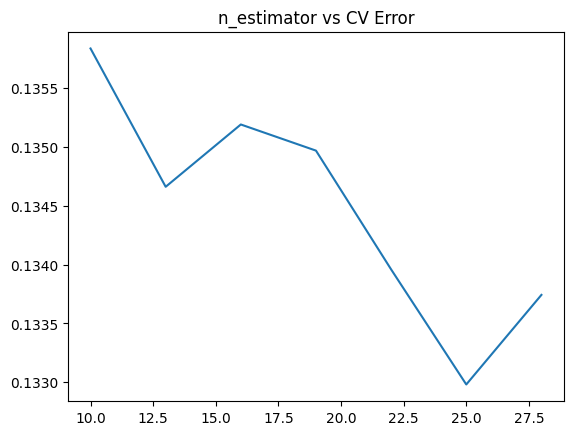

In [42]:
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")
#get best result for n_estimator=4

## Other emsemble method - boosting （AdaBoost+Ridge/XGboost)
XGboost is more advanced than AdaBoost in many ways. (1) It handles missing value internally (2) AdaBoost focus on error of previous models by adjusting sample weights.  XGboost uses gradient boosting with regularization, sophisticated tree pruning, and optimization techniques.

In [44]:
from sklearn.ensemble import AdaBoostRegressor
params = list(range(1,20,2))
test_scores = []
for param in params:
    clf = AdaBoostRegressor(n_estimators = param, base_estimator = ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5, 1.0, 'n_estimator vs CV Error')

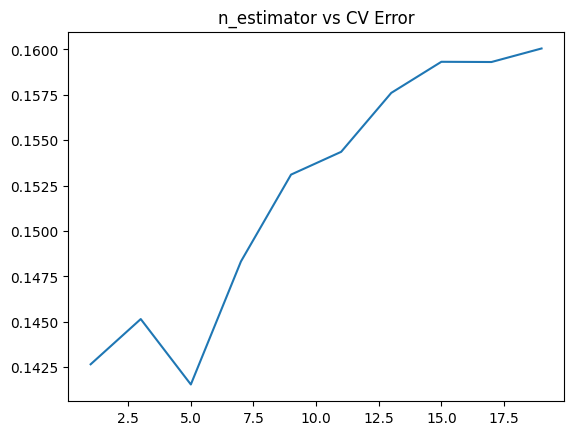

In [45]:
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")

In [46]:
from xgboost import XGBRegressor
params = list(range(1, 20,2))
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth = param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

Text(0.5, 1.0, 'n_estimator vs CV Error')

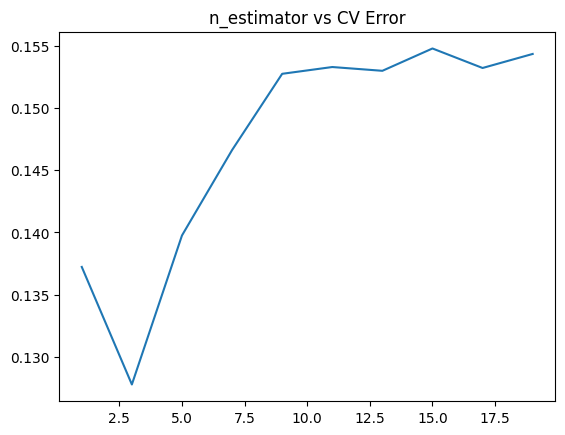

In [47]:
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error")

In [55]:
np.array(test_scores).min()

0.1277726797260797

Hooray! XGB outperforms all other models. With an MSE of  0.128.

### References:
1. Machine Learning: https://www.bilibili.com/video/BV19b411z73K?p=1&vd_source=000f1c5ca73e1bbcce94703549a69a8d
2. Ridge, LASSO, Elastic Net: https://ssc.ca/sites/default/files/data/Members/public/Publications/BookFiles/Book/79-91.pdf
3. XGBoost: https://xgboost.readthedocs.io/en/stable/